![MLU Logo](../../data/MLU_Logo.png)

# <a name="0">Responsible ML - Logistic Regression </a>


This notebook shows how to build a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model to predict whether an individuals' income is $\leq$ 50k or not using US census data.

__Dataset:__ 
The dataset we will use for this exercise is coming from [folktables](https://github.com/zykls/folktables). Folktables provide code to download data from the American Community Survey (ACS) Public Use Microdata Sample (PUMS) files managed by the US Census Bureau. The data itself is governed by the terms of use provided by the Census Bureau. For more information, see the [Terms of Service](https://www.census.gov/data/developers/about/terms-of-service.html).

__ML Problem:__ 
Ultimately, the goal will be to predict whether an individual's income is above \\$50,000. We will  filter the ACS PUMS data sample to only include individuals above the age of 16, who reported usual working hours of at least 1 hour per week in the past year, and an income of at least \\$100. The threshold of \\$50,000 was chosen so that this dataset can serve as a comparable substitute to the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult). The income threshold can be changed easily to define new prediction tasks.


1. <a href="#1">Read the dataset</a>
2. <a href="#2">Data Processing</a>
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Train - Validation - Test Datasets</a>
    * <a href="#24">Data processing with Pipeline and ColumnTransformer</a>
3. <a href="#3">Train (and Tune) a Classifier</a>
4. <a href="#4">Test the Classifier</a>
5. <a href="#5">Accuracy Difference and DPPL</a>


Before going into the model, let's have a quick look at how a linear regression can be turned into a logistic regression.

Let's assume we plot a feature (e.g. Class of Worker) vs the model target. As class of worker is a categorical feature we introduce a little jitter to see the data points more easily.

<img src="img/fig-data.png" alt="drawing" width="400" height="300"/>


We fit a linear regression through the data points.

<img src="img/fig-lr.png" alt="drawing" width="400" height="300"/>

This is not ideal as we can end up making predictions that are outside the model target range (0 or 1); a linear regression can predict values in the range ($-\inf$, $+\inf$). To squish the linear regression values into a range of 0 to 1, we can use the sigmoid function:

<center>
$\frac{1}{1 + \exp(- (w_{0} + w_{1}\cdot x_{1}+ w_{2}\cdot x_{2} + ...))}$
</center>  
<p><br></p>

This will create a so-called Logistic Regression and allow us to make binary predictions.

<img src="img/fig-lg.png" alt="drawing" width="400" height="300"/>


In [1]:
# Reshaping/basic libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Operational libraries
import sys
sys.path.append("..")

# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *

# Jupyter(lab) libraries
import warnings
warnings.filterwarnings("ignore")

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's import data from folktables.

In [2]:
income_features = [
    "AGEP",  # age individual
    "COW",   # class of worker
    "SCHL",  # educational attainment
    "MAR",   # marital status
    "OCCP",  # occupation
    "POBP",  # place of birth
    "RELP",  # relationship
    "WKHP",  # hours worked per week past 12 months
    "SEX",   # sex
    "RAC1P",  # recorded detailed race code
    "PWGTP",  # persons weight
    "GCL",   # grand parents living with grandchildren
]

# Define the prediction problem and features
ACSIncome = folktables.BasicProblem(
    features=income_features,
    target="PINCP",  # total persons income
    target_transform=lambda x: x > 50000,
    group="RAC1P",
    preprocess=adult_filter,  # applies the following conditions; ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    postprocess=lambda x: x,  # applies post processing, e.g. fill all NAs
)

# Initialize year, duration ("1-Year" or "5-Year") and granularity (household or person)
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
# Specify region (here: California) and load data
ca_data = data_source.get_data(states=["CA"], download=True)
# Apply transformation as per problem statement above
ca_features, ca_labels, ca_group = ACSIncome.df_to_numpy(ca_data)

# Convert numpy array to dataframe
df = pd.DataFrame(
    np.concatenate((ca_features, ca_labels.reshape(-1, 1)), axis=1),
    columns=income_features + [">50k"],
)

# For further modelling we want to use only 2 groups (see DATAPREP notebook for details)
df = df[df["RAC1P"].isin([1, 8])].copy(deep = True)

## 2. <a name="2">Data Processing</a>
(<a href="#0">Go to top</a>)

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the dataset.

In [3]:
# Print the first five rows
# NaN means missing data
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PWGTP,GCL,>50k
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,32.0,2.0,0.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0,52.0,NaN,0.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0,33.0,2.0,0.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0,53.0,2.0,0.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0,106.0,NaN,0.0


In [4]:
# Check how many rows and columns we have in the data frame
print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (143799, 13)


In [5]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143799 entries, 0 to 195664
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AGEP    143799 non-null  float64
 1   COW     143799 non-null  float64
 2   SCHL    143799 non-null  float64
 3   MAR     143799 non-null  float64
 4   OCCP    143799 non-null  float64
 5   POBP    143799 non-null  float64
 6   RELP    143799 non-null  float64
 7   WKHP    143799 non-null  float64
 8   SEX     143799 non-null  float64
 9   RAC1P   143799 non-null  float64
 10  PWGTP   143799 non-null  float64
 11  GCL     109947 non-null  float64
 12  >50k    143799 non-null  float64
dtypes: float64(13)
memory usage: 15.4 MB


We can clearly see that all columns are numerical (`dtype = float64`). However, when checking the column headers (and information at top of the notebook), we should notice that we are actually dealing with multimodal data. We expect to see a mix of categorical, numerical and potentially even text information.

Let's cast the features accordingly. We start by creating list for each feature type.

In [6]:
categorical_features = [
    "COW",
    "SCHL",
    "MAR",
    "OCCP",
    "POBP",
    "RELP",
    "SEX",
    "RAC1P",
    "GCL",
]

numerical_features = ["AGEP", "WKHP", "PWGTP"]

In [7]:
# We cast categorical features to `category`
df[categorical_features] = df[categorical_features].astype("object")

# We cast numerical features to `int`
df[numerical_features] = df[numerical_features].astype("int")

Let's check with `.info()` again to make sure the changes took effect.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143799 entries, 0 to 195664
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AGEP    143799 non-null  int64  
 1   COW     143799 non-null  object 
 2   SCHL    143799 non-null  object 
 3   MAR     143799 non-null  object 
 4   OCCP    143799 non-null  object 
 5   POBP    143799 non-null  object 
 6   RELP    143799 non-null  object 
 7   WKHP    143799 non-null  int64  
 8   SEX     143799 non-null  object 
 9   RAC1P   143799 non-null  object 
 10  PWGTP   143799 non-null  int64  
 11  GCL     109947 non-null  object 
 12  >50k    143799 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 15.4+ MB


Looks good, so we can now seperate model features from model target to explore them separately.

In [9]:
model_target = ">50k"
model_features = categorical_features + numerical_features

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'RAC1P', 'GCL', 'AGEP', 'WKHP', 'PWGTP']
Model target:  >50k


In [10]:
# Double check that that target is not accidentally part of the features
model_target in model_features

False

All good here. We made sure that the target is not in the feature list. If we find the above statement showing `True` we need to remove the target by calling `model_features.remove(model_target)`.

Let's have a look at missing values next.


#### Missing values
The quickest way to check for missing values is to use `.isna().sum()`. This will provide a count of how many missing values we have. In fact, we can also see the count of missing values with `.info()` as it provided a count of non-null values.

In [11]:
# Show missing values
df.isna().sum()

AGEP         0
COW          0
SCHL         0
MAR          0
OCCP         0
POBP         0
RELP         0
WKHP         0
SEX          0
RAC1P        0
PWGTP        0
GCL      33852
>50k         0
dtype: int64

Before starting with the plots, let's have a look at how many unique instances we have per column. This helps us avoid plotting charts with hundreds of unique values. Let's filter for columns with fewer than 10 unique instances.

In [12]:
shortlist_fts = (
    df[model_features]
    .apply(lambda col: col.nunique())
    .where(df[model_features].apply(lambda col: col.nunique()) < 10)
    .dropna()
)

print(shortlist_fts)

COW      8.0
MAR      5.0
SEX      2.0
RAC1P    2.0
GCL      2.0
dtype: float64


#### Target distribution

Let's check our target distribution.

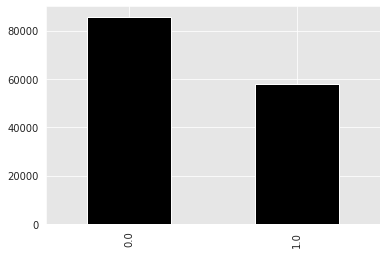

In [13]:
df[model_target].value_counts().plot.bar(color="black")
plt.show()

We notice that we are dealing with an imbalanced dataset. This means there are more examples for one type of results (here: 0; meaning individuals earning $\leq$ 50k). This is relevant for model choice and potential up-sampling or down-sampling to balance out the classes.

#### Feature distribution(s)

Let's now plot bar charts for the shortlist features of our dataset (as per above: shortlist - feature columns with less than 10 unique instance classes).

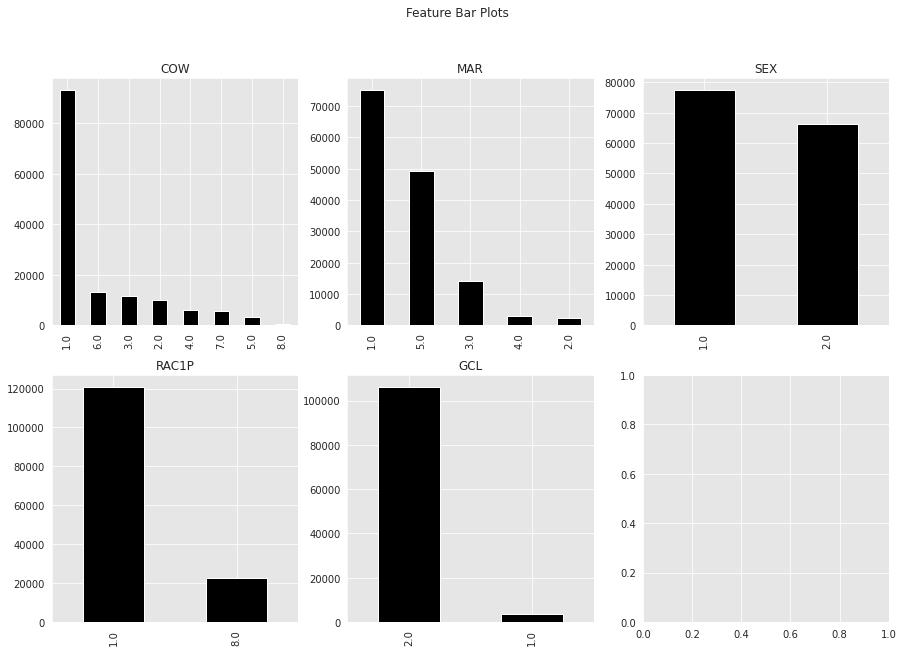

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Feature Bar Plots")

fts = range(len(shortlist_fts.index.tolist()))
for i, ax in zip(fts, axs.ravel()):
    df[shortlist_fts.index.tolist()[i]].value_counts().plot.bar(color="black", ax=ax)
    ax.set_title(shortlist_fts.index.tolist()[i])
plt.show()

### 2.2 <a name="22">Select features to build the model</a>
(<a href="#2">Go to Data Processing</a>)

During the extended EDA in the DATAPREP notebook, we learned that `GCL` is a feature that is equally present in both outcome instances and also contains a lot of missing values. Therefore, we can drop it from the list of features we want to use for model build.

In [15]:
to_remove = "GCL"

# Drop 'GCL' feature from the respective list(s) - if applicable
if to_remove in model_features:
    model_features.remove(to_remove)
if to_remove in categorical_features:
    categorical_features.remove(to_remove)
if to_remove in numerical_features:
    numerical_features.remove(to_remove)

# Let's also clean up the dataframe and only keep the features and columns we need
df = df[model_features + [model_target]].copy(deep=True)

### 2.3 <a name="23">Train - Validation - Test Datasets</a>
(<a href="#2">Go to Data Processing</a>)

To get a training, test and validation set, we will use sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [16]:
train_data, test_data = train_test_split(
    df, test_size=0.1, shuffle=True, random_state=23
)
train_data, val_data = train_test_split(
    train_data, test_size=0.15, shuffle=True, random_state=23
)

# Print the shapes of the Train - Test Datasets
print(
    "Train - Test - Validation datasets shapes: ",
    train_data.shape,
    test_data.shape,
    val_data.shape,
)

Train - Test - Validation datasets shapes:  (110006, 12) (14380, 12) (19413, 12)


### 2.4 <a name="24">Data processing with Pipeline and ColumnTransformer</a>
(<a href="#2">Go to Data Processing</a>)

Let's build a full model pipeline. We need pre-processing split per data type, and then combine everything back into a composite pipeline along with a model. To achieve this, we will use sklearns `Pipeline` and `ColumnTransformer`.

__Step 1 (set up pre-processing per data type):__
> For the numerical features pipeline, the __numerical_processor__ below, we impute missing values with the mean using sklearn's `SimpleImputer`, followed by a `MinMaxScaler` (don't have to scale features when using Decision Trees, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.

 > In the categorical features pipeline, the __categorical_processor__ below, we impute with a placeholder value and encode with sklearn's `OneHotEncoder`. If computing memory is an issue, it is a good idea to check categoricals' unique values, to get an estimate of many dummy features will be created by one-hot encoding. Note the __handle_unknown__ parameter that tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation/and or test set that was not present in the initial training set.
 
__Step 2 (combining pre-processing methods into a transformer):__ 
 > The selective preparations of the dataset features are then put together into a collective `ColumnTransformer`, to be finally used in a Pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.
   
__Step 3 (combining transformer with a model):__ 
> Combine `ColumnTransformer` from Step 2 with a selected algorithm in a new pipeline. For example, the algorithm could be a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for classification problems.

In [17]:
### STEP 1 ###
##############

# Preprocess the numerical features
numerical_processor = Pipeline(
    [("num_imputer", SimpleImputer(strategy="mean")), ("num_scaler", MinMaxScaler())]
)
# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("cat_encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

### STEP 2 ###
##############

# Combine all data preprocessors from above
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
    ]
)

### STEP 3 ###
##############

# Pipeline desired all data transformers, along with an estimator at the end
# Later you can set/reach the parameters using the names issued - for hyperparameter tuning, for example
pipeline = Pipeline(
    [
        ("data_processing", data_processor),
        ("lg", LogisticRegression(solver="liblinear", penalty="l2", C=0.001)),
    ]
)

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config

set_config(display="diagram")
pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['AGEP', 'WKHP', 'PWGTP']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['COW', 'SCHL', 'MAR', 'OCCP',
                                                   'POBP', 'RELP', 'SEX',
                                                   'RAC1P'])])),
                ('lg', LogisticRegression(C=0.001, solver='liblinear'))])

## 3. <a name="3">Train a Classifier</a>
(<a href="#0">Go to top</a>)

We use the pipeline with the desired data transformers, along with a Logistic Regression estimator for training.


### Model Training

We train the classifier with __.fit()__ on our training dataset. 

In [18]:
# Get train data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the train data
# Train data going through the Pipeline it's imputed (with means from the train data),
#   scaled (with the min/max from the train data),
#   and finally used to fit the model
pipeline.fit(X_train, y_train);

In [19]:
# Get train data to train the classifier
X_val = val_data[model_features]
y_val = val_data[model_target]

y_val_pred = pipeline.predict(X_val)

print("Model performance on the validation set:")
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

Model performance on the validation set:
Validation accuracy: 0.7827744295060012


## 4. <a name="4">Test the Classifier</a>
(<a href="#0">Go to top</a>)

Let's now evaluate the performance of the trained classifier on the test dataset. We use __.predict()__ this time. 


In [20]:
# Get validation data to validate the classifier
X_test = test_data[model_features]
y_test = test_data[model_target]

# Use the fitted model to make predictions on the test dataset
# Test data going through the Pipeline it's imputed (with means from the train data),
#   scaled (with the min/max from the train data),
#   and finally used to make predictions
test_predictions = pipeline.predict(X_test)

print("Model performance on the test set:")
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Model performance on the test set:
Test accuracy: 0.7776077885952712


## 5. <a name="5">Accuracy Difference and DPPL</a>
(<a href="#0">Go to top</a>)


### DPPL
DPPL (Difference in Proportion of Predicted Labels) is an extension of DPL where the outcome we compare is the prediction the model creates (rather than the ground truth value). The equation remains basically the same, only we are counting positive outcomes as per model prediction:

> $DPPL = \frac{\hat{n}_{pred>50k \wedge RACP1=1}}{n_{RACP1=1}} - \frac{\hat{n}_{pred>50k \wedge RACP1=8}}{n_{RACP1=8}}$

To calculate DPPL more easily, let's write a function for it that can take different parameters.

In [21]:
def dpl(sensitive_attribute_name, attr_val,target, dataframe):
    """Function to calculate DPL or DPPL (depending on specified target)."""
    for val in attr_val:
        globals()[f'n_pos_gr{val}'] = len(
            dataframe[(dataframe[target] == 1) & (dataframe[sensitive_attribute_name] == val)]
        )
        globals()[f'n_gr{val}'] = len(dataframe[dataframe[sensitive_attribute_name] == val])

    dpl = n_pos_gr1 / n_gr1 - n_pos_gr8 / n_gr8
    return dpl

In [22]:
# Create dataframe that contains predictions and the sensitive attribute
dpl_df = pd.concat(
    [
        test_data.reset_index(drop=True)[["RAC1P", ">50k"]],
        pd.Series(test_predictions, name="y_test_pred"),
    ],
    axis=1,
)

dpl("RAC1P", [1, 8], "y_test_pred", dpl_df)

0.38173487485637414

Let's compare this to the original DPL value (the difference in proportion of labels in the original dataframe):

In [23]:
dpl("RAC1P", [1, 8], ">50k", test_data)

0.2582429021033461

The DPL value is smaller than the DPPL value. It seems that the model is producing a more biased output compared to the ground truth data. This could be due to the different success rates for the different groups in our model. Generally, models will make better predictions for the larger group (meaning, the larger group drives the overall model performance and whatever outcome is dominant in the larger group, will occur more frequently in the predictions).

Let's see if we can observe this behavior in our model predictions and calculate overall accuracy first.

In [24]:
# Accuracy score across all groups
accuracy_score(
    dpl_df[">50k"], dpl_df["y_test_pred"]
)

0.7776077885952712

Let's also have a look at the accuracy difference between `RACP1=1` and `RACP1=8`.

In [25]:
# Accuracy score for RACP1=1
acc_gr1 = accuracy_score(
    dpl_df[dpl_df["RAC1P"] == 1][">50k"], dpl_df[dpl_df["RAC1P"] == 1]["y_test_pred"]
)

acc_gr1

0.7679290232481721

In [26]:
# Accuracy score for RACP1=8
acc_gr8 = accuracy_score(
    dpl_df[dpl_df["RAC1P"] == 8][">50k"], dpl_df[dpl_df["RAC1P"] == 8]["y_test_pred"]
)

acc_gr8

0.830992297236067

### Accuracy Difference
We calculate the Accuracy Difference by subtracting the two values we calculated above:

In [27]:
acc_gr1 - acc_gr8

-0.06306327398789491

Interestingly the accuracy for the group we assume to be at a disadvantage is higher than the accuracy for the favored group. We can dive deeper to see what's going on and plot the confusion matrix and we should also look at confidence intervals.

In [28]:
# Confusion matrix for RACP1=8
confusion_matrix(
    dpl_df[dpl_df["RAC1P"] == 8][">50k"], dpl_df[dpl_df["RAC1P"] == 8]["y_test_pred"]
)

array([[1763,   34],
       [ 339,   71]])

Let's compare this confusion matrix with the one for the favored group.

In [29]:
# Confusion matrix for RACP1=1
confusion_matrix(
    dpl_df[dpl_df["RAC1P"] == 1][">50k"], dpl_df[dpl_df["RAC1P"] == 1]["y_test_pred"]
)

array([[5445, 1323],
       [1502, 3903]])

We observe that the errors are not balanced between false positives and false negatives for the disfavored group. There is a much larger share of false negatives (predicted salary as $\leq$ 50k, when it was actually higher) than false positives. This result is concerning for multiple reasons:
1. It gives the impression that the model is undervaluing the disfavored group (the group has more $\leq$ 50k salaries) than there are in reality.
2. If this model is used to show job ads based on a 50k salary threshold, a lot of individuals in the disfavored group that should have been eligible to see the ad, won't receive it. This causes a negative reinforcement of existing bias.

The imbalance is not as drastic for the favored group. We still observe an overall skew towards the $\leq$ 50k class which is expected as most classification models (unless specifically instructed not to), tend to favor the outcome class that has more examples. In our case, the outcome class with more examples is the $\leq$ 50k class and we can observe that across both groups, we are over-predicting for $\leq$ 50k. We can also verify this visually by looking at the distribution of label and predictions.

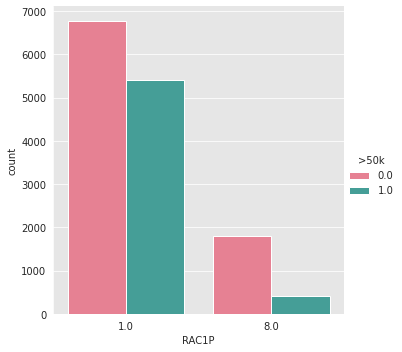

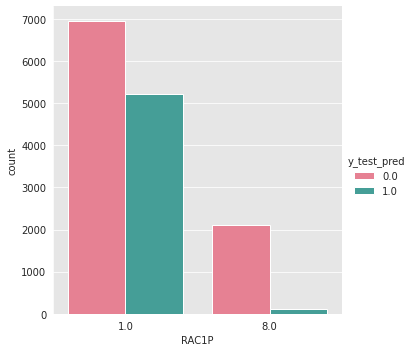

In [30]:
sns.catplot(x="RAC1P", kind="count", hue=model_target, data=dpl_df, palette="husl")
sns.catplot(x="RAC1P", kind="count", hue="y_test_pred", data=dpl_df, palette="husl")
plt.show()

This is the end of the notebook.